# Телеком — задача проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## Предобработка данных

Импортируем все библиотеки:

In [2]:
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import cross_validate,train_test_split,RandomizedSearchCV,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn import metrics

Запишем все датафреймы в переменные,а также образуем из них словарь,для дальнейшего прохода по нему функцией all_about_dataframe

In [4]:
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')
all_data={"contract": contract,
          "personal":personal,
          "internet":internet,
          "phone":phone
         }

In [5]:
def all_about_dataframe(data):
    print("Head:")
    display(data.head(5))
    print()
    print("Info:")
    print(data.info())
    print()
    print("How many NaN:")
    print(data.isna().sum())
    print()
    print("Statistic:")
    print()
    display(data.describe(include='all'))

В цикле применим функцию ко всем таблицам

In [6]:
for i in all_data:
    print(i)
    all_about_dataframe(all_data[i])

contract
Head:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None

How many NaN:
customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

Statistic:



,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,77,5,3,2,4,NaN,6531
top,2951-QOQTK,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,1,366,5174,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


personal
Head:


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None

How many NaN:
customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

Statistic:



,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,2951-QOQTK,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN


internet
Head:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None

How many NaN:
customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

Statistic:



,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,9947-OTFQU,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


phone
Head:


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None

How many NaN:
customerID       0
MultipleLines    0
dtype: int64

Statistic:



,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,2951-QOQTK,No
freq,1,3390


Результат проходки функции:

Пропусков ни в одной таблице необнаружено, в столбце EndDate 5174 значений No.

1. contract

- BeginDate имеет тип object,следует перевести к дате
- EndDate является целевой переменной,ее следует привести к формату 0/1
- PaperlessBilling следует также привести к формату 0/1
- TotalCharges имеет тип object,следует привести его к типу float

2. personal
- Все переменные,кроме customerId и SeniorCitizen нужно привести к формату 0/1

3. internet
- Все переменные,кроме InternetService и SeniorCitizen нужно привести к формату 0/1

4. phone
- MulptipleLines привести к формату 0/1

In [7]:
def encoder(table,column):
    l_encoder=LabelEncoder()
    table[column]=l_encoder.fit_transform(table[column])
    
def end_date(date):
    if date is pd.NaT:
        return 1
    else:
        return 0
    
default = pd.to_datetime('2020-02-01', format='%Y-%m-%d')
   
def full_lif(data):
    begin = data['BeginDate']
    end = data['EndDate']
    def days(d1, d2):
        return (d1 - d2).days
    if end is pd.NaT:
        full_time= days(default, begin)
    else:
        full_time = days(end, begin)
    return full_time

In [8]:
contract_encoding=["PaperlessBilling","Type","PaymentMethod"]
personal_encoding=["gender","Partner","Dependents"]
internet_encoding=["OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies","InternetService"]
phone_encoding=["MultipleLines"]
for i in contract_encoding:
    encoder(contract,i)
for j in personal_encoding:
    encoder(personal,j)
for k in internet_encoding:
    encoder(internet,k)
for l in phone_encoding:
    encoder(phone,l)
contract["BeginDate"]=pd.to_datetime(contract["BeginDate"],format='%Y-%m-%d',errors='coerce')
contract["EndDate"]=pd.to_datetime(contract["EndDate"],format='%Y-%m-%d',errors='coerce')
contract["TotalCharges"]=pd.to_numeric(contract["TotalCharges"],errors='coerce')
contract['FullTime']=contract.apply(full_lif,axis=1)
contract["EndDate"]=contract["EndDate"].map(end_date)


In [9]:
for i in all_data:
    print(i)
    all_about_dataframe(all_data[i])

contract
Head:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,FullTime
0,7590-VHVEG,2020-01-01,1,0,1,2,29.85,29.85,31
1,5575-GNVDE,2017-04-01,1,1,0,3,56.95,1889.50,1036
2,3668-QPYBK,2019-10-01,0,0,1,3,53.85,108.15,61
3,7795-CFOCW,2016-05-01,1,1,0,0,42.30,1840.75,1371
4,9237-HQITU,2019-09-01,0,0,1,2,70.70,151.65,61



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   int64         
 3   Type              7043 non-null   int32         
 4   PaperlessBilling  7043 non-null   int32         
 5   PaymentMethod     7043 non-null   int32         
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   FullTime          7043 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int32(3), int64(2), object(1)
memory usage: 412.8+ KB
None

How many NaN:
customerID           0
BeginDate            0
EndDate              0
Type                 0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges       

<ipython-input-5-d1221857bbcf>:13: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(data.describe(include='all'))


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,FullTime
count,7043,7043,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7032.000000,7043.000000
unique,7043,77,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2951-QOQTK,2014-02-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,366,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,2013-10-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2020-02-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,0.734630,0.690473,0.592219,1.574329,64.761692,2283.300441,985.996166
std,NaN,NaN,0.441561,0.833755,0.491457,1.068104,30.090047,2266.771362,747.587844
min,NaN,NaN,0.000000,0.000000,0.000000,0.000000,18.250000,18.800000,0.000000
25%,NaN,NaN,0.000000,0.000000,0.000000,1.000000,35.500000,401.450000,273.000000


personal
Head:


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,0,0,1,0
1,5575-GNVDE,1,0,0,0
2,3668-QPYBK,1,0,0,0
3,7795-CFOCW,1,0,0,0
4,9237-HQITU,0,0,0,0



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   int32 
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   int32 
 4   Dependents     7043 non-null   int32 
dtypes: int32(3), int64(1), object(1)
memory usage: 192.7+ KB
None

How many NaN:
customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

Statistic:



,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043.000000,7043.000000,7043.000000,7043.000000
unique,7043,NaN,NaN,NaN,NaN
top,2951-QOQTK,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN
mean,NaN,0.504756,0.162147,0.483033,0.299588
std,NaN,0.500013,0.368612,0.499748,0.458110
min,NaN,0.000000,0.000000,0.000000,0.000000
25%,NaN,0.000000,0.000000,0.000000,0.000000
50%,NaN,1.000000,0.000000,0.000000,0.000000
75%,NaN,1.000000,0.000000,1.000000,1.000000


internet
Head:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,0,0,1,0,0,0,0
1,5575-GNVDE,0,1,0,1,0,0,0
2,3668-QPYBK,0,1,1,0,0,0,0
3,7795-CFOCW,0,1,0,1,1,0,0
4,9237-HQITU,1,0,0,0,0,0,0



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   int32 
 2   OnlineSecurity    5517 non-null   int32 
 3   OnlineBackup      5517 non-null   int32 
 4   DeviceProtection  5517 non-null   int32 
 5   TechSupport       5517 non-null   int32 
 6   StreamingTV       5517 non-null   int32 
 7   StreamingMovies   5517 non-null   int32 
dtypes: int32(7), object(1)
memory usage: 194.1+ KB
None

How many NaN:
customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

Statistic:



,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517.000000,5517.000000,5517.000000,5517.000000,5517.000000,5517.000000,5517.000000
unique,5517,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,9947-OTFQU,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.561175,0.365960,0.440276,0.439007,0.370491,0.490665,0.495197
std,NaN,0.496289,0.481742,0.496465,0.496311,0.482980,0.499958,0.500022
min,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


phone
Head:


,customerID,MultipleLines
0,5575-GNVDE,0
1,3668-QPYBK,0
2,9237-HQITU,0
3,9305-CDSKC,1
4,1452-KIOVK,1



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 74.7+ KB
None

How many NaN:
customerID       0
MultipleLines    0
dtype: int64

Statistic:



,customerID,MultipleLines
count,6361,6361.000000
unique,6361,NaN
top,2951-QOQTK,NaN
freq,1,NaN
mean,NaN,0.467065
std,NaN,0.498953
min,NaN,0.000000
25%,NaN,0.000000
50%,NaN,0.000000
75%,NaN,1.000000


Соединим таблицы в итоговую

In [10]:
data=contract.set_index('customerID').join(personal.set_index('customerID')).join(internet.set_index('customerID')).join(phone.set_index('customerID'))

In [12]:
data=data.fillna(0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   int64         
 2   Type              7043 non-null   int32         
 3   PaperlessBilling  7043 non-null   int32         
 4   PaymentMethod     7043 non-null   int32         
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   FullTime          7043 non-null   int64         
 8   gender            7043 non-null   int32         
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   int32         
 11  Dependents        7043 non-null   int32         
 12  InternetService   7043 non-null   float64       
 13  OnlineSecurity    7043 non-null   float64       
 14  OnlineBackup  

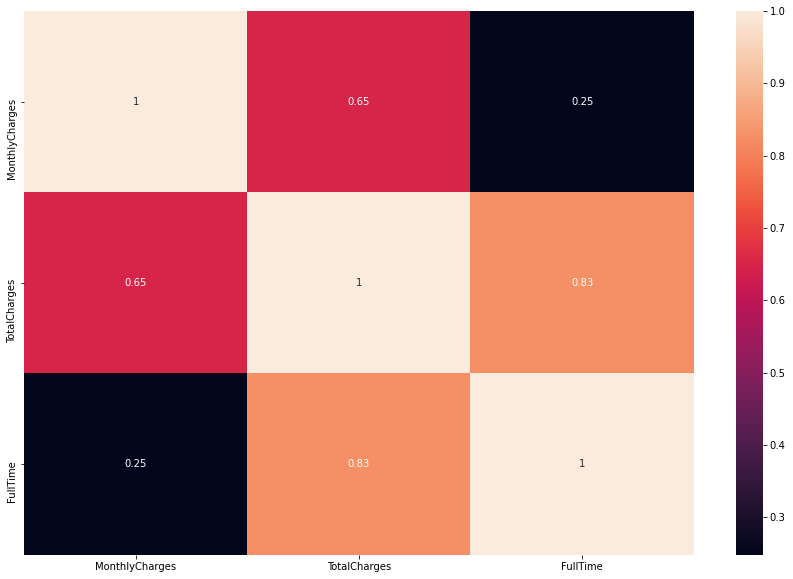

In [13]:
fig,ax=plt.subplots(figsize=(15,10))
sns.heatmap(data[['MonthlyCharges','TotalCharges','FullTime']].corr(),annot=True);

Исходя из корреляций между некоторыми признаками,удалим столбцы TotalCharges и InternetService
Сразу же делим на обучающую и тестовую выборку

In [12]:
feature=data.drop(['EndDate','BeginDate','TotalCharges','InternetService'],axis=1)
target=data['EndDate']

In [13]:
feature

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,FullTime,gender,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,
7590-VHVEG,0,1,2,29.85,31,0,0,1,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5575-GNVDE,1,0,3,56.95,1036,1,0,0,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3668-QPYBK,0,1,3,53.85,61,1,0,0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
7795-CFOCW,1,0,0,42.30,1371,1,0,0,0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
9237-HQITU,0,1,2,70.70,61,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,1,1,3,84.80,730,1,0,1,1,1.0,0.0,1.0,1.0,1.0,1.0,1.0
2234-XADUH,1,1,1,103.20,2191,0,0,1,1,0.0,1.0,1.0,0.0,1.0,1.0,1.0
4801-JZAZL,0,1,2,29.60,337,0,0,1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Подбор и обучение

Выведем самые значимые параметры для обучения,на примере модели случайного леса

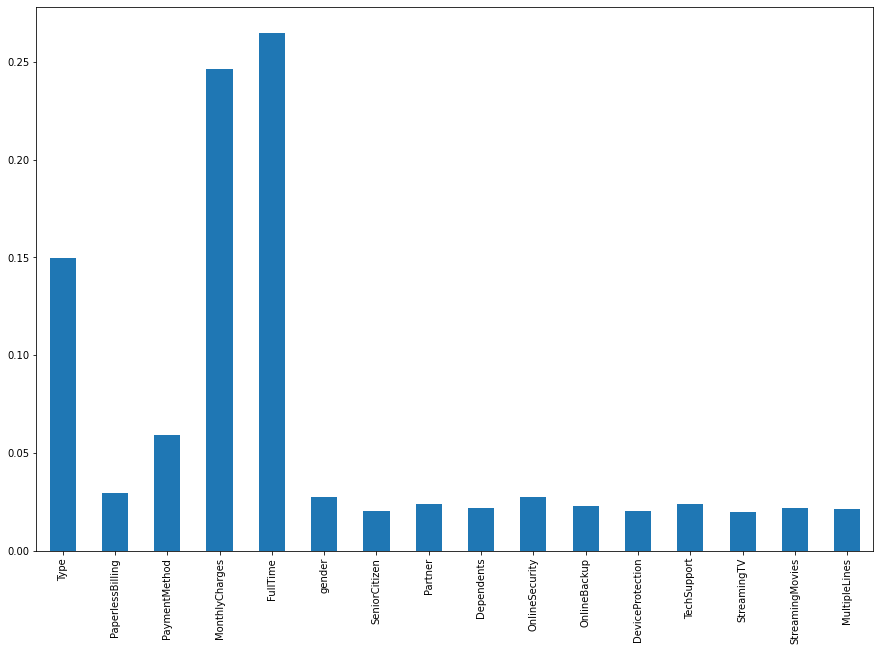

In [14]:
model=RandomForestClassifier(random_state=12345,n_estimators=100,class_weight='balanced')
model.fit(feature,target)
priznaki=pd.Series(model.feature_importances_,feature.columns)
fig,ax=plt.subplots(figsize=(15,10))
priznaki.plot.bar(ax=ax);


Самыми значимыми столбцами являются FullTime,MonthlyCharges,Type,PaymentMethod,оставим только их

In [15]:
feature = feature.loc[:, ['FullTime', 'MonthlyCharges', 'Type', 'PaymentMethod']]

In [17]:
feature_train, feature_test, target_train, target_test = train_test_split(feature, target, test_size=0.25, random_state=12345)

Напишем функцию для подсчета результата

In [67]:
def get_score(model, X_train, y_train):
    clf = model.fit(X_train, y_train)
    res = cross_val_score(clf, X_train, y_train, scoring='roc_auc', cv=5)#результатом будет массив из 5 элементов(для каждого блока)
    accuracy = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=5)#результатом будет массив из 5 элементов(для каждого блока)
    print('roc_auc ',np.mean(res))#в качестве результата возвращаем среднее
    print('accuracy ',np.mean(accuracy))

Далее напишем функцию для полбора параметров:

In [83]:
def get_best_params(features, target, model, parameters):
    clf = RandomizedSearchCV(model,parameters,scoring='accuracy', cv = 5,random_state=12345)#GridSearchCV слишком долго работал на градиентном бустинге,поэтому была взята случайная модель
    best = clf.fit(features, target)
    print('Best Params: ', best.best_params_)

In [79]:
model = RandomForestClassifier(random_state=124, class_weight='balanced')
parameters ={'max_depth':np.arange(1, 11), 
             'n_estimators':np.arange(50, 200, 50)}
get_best_params(feature_train, target_train, model, parameters)

Best Params:  {'n_estimators': 150, 'max_depth': 9}


In [80]:
model = GradientBoostingClassifier(random_state=124)
parameters ={'max_depth':np.arange(1, 11),
             'n_estimators':np.arange(50, 200, 50), 
             'learning_rate':np.arange(0.01, 1, 0.05)}
get_best_params(feature_train, target_train, model, parameters)

Best Params:  {'n_estimators': 150, 'max_depth': 2, 'learning_rate': 0.46}


In [73]:
rfc = RandomForestClassifier(random_state=124, n_estimators=150, max_depth=10, class_weight='balanced')
get_score(rfc, feature, target)

roc_auc  0.8635575349422819
accuracy  0.7871655026130717


In [82]:
gbc = GradientBoostingClassifier(random_state=124, n_estimators=150, max_depth=2, learning_rate=0.46)
get_score(gbc, feature, target)

roc_auc  0.921969184255979
accuracy  0.874344211723337


(0.921969184255979, 0.874344211723337)

## Вывод

Таким образом лучший результат показала модель GradientBoostingClassifier, с результатами roc_auc=0.92 и accuracy 0.8743.
Был также проведен предварительный анализ,статистические зависимости позволили нам избавиться от нескольих признаков,затем были проведены подбор и обучение моделей